<a href="https://colab.research.google.com/github/ykro/ML-SP1-2021/blob/main/Lesson-04/L4N5_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import files

import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
steps = 20
epochs = 20
batch_size = 64
image_size = (150, 150)
class_names = np.array(['cat','dog'])
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [ ]:
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 1s 0us/step


In [ ]:
#!ls ~/.keras/datasets/cats_and_dogs_filtered/train/cats
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  
train_dogs_dir = os.path.join(train_dir, 'dogs')  
validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs') 

num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [ ]:
def build_model(layers, opt=Adam()):
  model = Sequential(layers)

  model.compile(optimizer=opt,
                loss='binary_crossentropy',
                metrics=['accuracy'])
  
  model.summary()

  return model

def plot_images(imgs,labels=np.array([])):
  plt.figure(figsize=(15,15))
  plt.subplots_adjust(hspace=0.5)

  for i in range(10):
    plt.axis("off")
    plt.subplot(4,5,i+1)
    plt.imshow(imgs[i])
    if labels.size:
      plt.title(class_names[int(labels[i])])

def plot_model(history, prev_history=None):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss'] 

  if prev_history is not None:
    acc = prev_history.history['accuracy'] + acc
    val_acc = prev_history.history['val_accuracy'] + val_acc

    loss = prev_history.history['loss'] + loss
    val_loss = prev_history.history['val_loss'] + val_loss

    initial_epochs = len(prev_history.history['accuracy'])

  plt.figure(figsize=(10, 10))

  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  
  if prev_history is not None:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')

  plt.legend(loc='lower right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')

  if prev_history is not None:
    plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
      
  plt.legend(loc='upper right')
  plt.setp(plt.legend().get_texts(), color='black')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.show()

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=image_size,
    class_mode='binary'
)

val_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    shuffle=True,
    target_size=image_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
sample_train_images, sample_train_labels = next(train_data_gen)
sample_train_images.shape, sample_train_labels.shape

((64, 150, 150, 3), (64,))

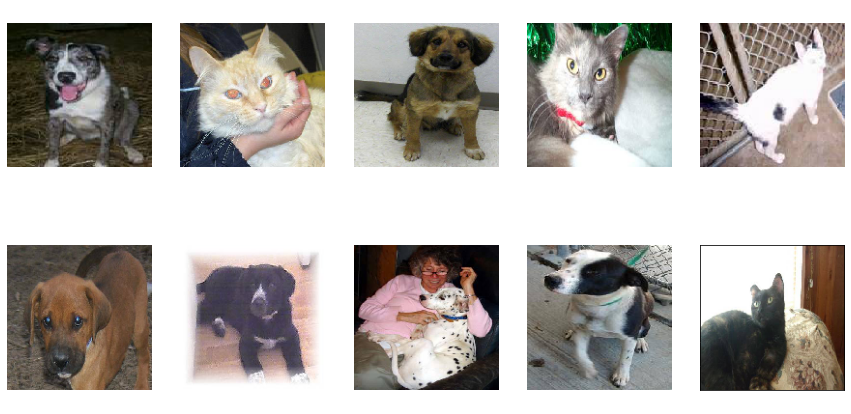

In [ ]:
plot_images(sample_train_images, sample_train_labels)

In [ ]:
m0 = build_model([
  Flatten(input_shape=image_size+(3,)),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              69121024  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 69,122,049
Trainable params: 69,122,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
h0 = m0.fit(
  train_data_gen,
  epochs=epochs,
  steps_per_epoch=steps,
  validation_data=val_data_gen,
  validation_steps=steps // 2
)

Epoch 1/20
20/20 [==============================] - 7s 281ms/step - loss: 50.4006 - accuracy: 0.5089 - val_loss: 1.2147 - val_accuracy: 0.5047
Epoch 2/20
20/20 [==============================] - 5s 260ms/step - loss: 0.8424 - accuracy: 0.5398 - val_loss: 0.6969 - val_accuracy: 0.5437
Epoch 3/20
20/20 [==============================] - 5s 269ms/step - loss: 0.6913 - accuracy: 0.5638 - val_loss: 0.6825 - val_accuracy: 0.5562
Epoch 4/20
20/20 [==============================] - 5s 258ms/step - loss: 0.6735 - accuracy: 0.6005 - val_loss: 0.7473 - val_accuracy: 0.5813
Epoch 5/20
20/20 [==============================] - 5s 260ms/step - loss: 0.8211 - accuracy: 0.5455 - val_loss: 0.7313 - val_accuracy: 0.5641
Epoch 6/20
20/20 [==============================] - 5s 265ms/step - loss: 0.7340 - accuracy: 0.6063 - val_loss: 0.6926 - val_accuracy: 0.5625
Epoch 7/20
20/20 [==============================] - 5s 270ms/step - loss: 0.6253 - accuracy: 0.6610 - val_loss: 0.7717 - val_accuracy: 0.5375
Epoch

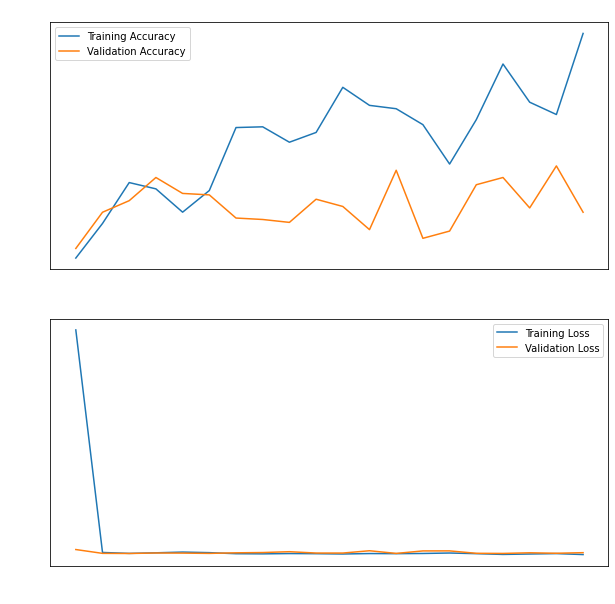

In [ ]:
plot_model(h0)

In [ ]:
augmented_image_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15
)

augmented_train_data_gen = augmented_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=image_size,
    class_mode='binary'
)

augmented_val_data_gen = augmented_image_gen.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=image_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


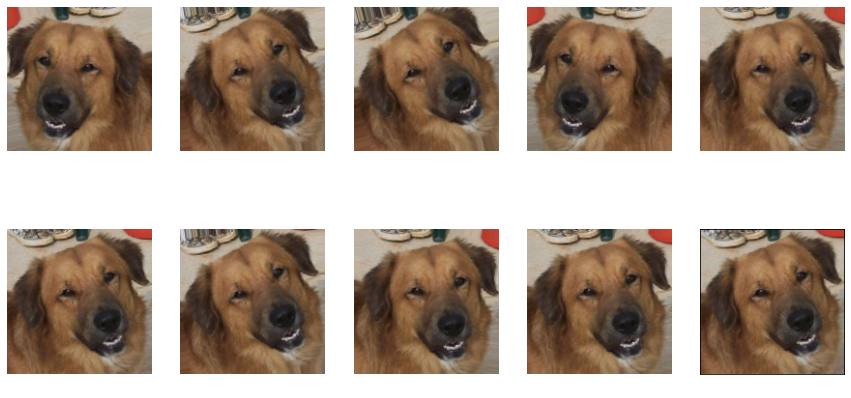

In [ ]:
plot_images([augmented_train_data_gen[0][0][0] for i in range(10)])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              69121024  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 69,122,049
Trainable params: 69,122,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
20/20 [==============================] - 11s 519ms/step - loss: 108.4731 - accuracy: 0.4997 - val_loss: 26.3882 - val_accuracy: 0.5078
Epoch 2/20
20/20 [==============================] - 10s 497ms/step - loss: 14.4573 - accuracy:

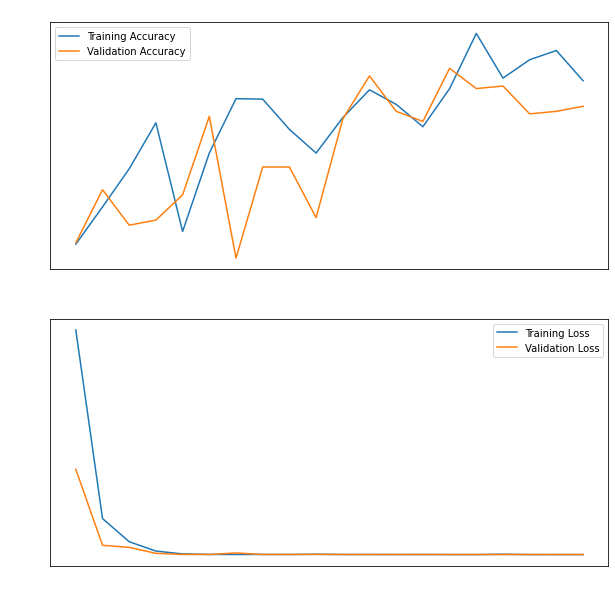

In [ ]:
m1 = build_model([
  Flatten(input_shape=image_size+(3,)),
  Dense(1024, activation='relu'),
  Dropout(0.2),
  Dense(1, activation='sigmoid')
])

h1 = m1.fit(
  augmented_train_data_gen,
  epochs=epochs,
  steps_per_epoch=steps,
  validation_data=val_data_gen,
  validation_steps=steps // 2
)

plot_model(h1)